In [91]:
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation

In [93]:
plt.style.use("seaborn")

In [94]:
lab_results = pd.read_csv("bt_dir_finding_lab_results.csv")
lab_results.head()

,x,y,z,measured_azimuth,measured_elevation
0,0.00,0.00,0.0,-5,1
1,4.99,0.00,0.0,40,30
2,10.20,0.00,0.0,-50,0
3,13.30,0.00,0.0,-50,30
4,0.00,4.02,0.0,-5,-36


In [95]:
lab_results["expected_azimuth"] = np.rad2deg(
    np.arctan2(lab_results["x"], lab_results["y"])
)
lab_results["expected_elevation"] = np.rad2deg(
    np.arctan2(lab_results["z"], np.sqrt(lab_results["x"] ** 2 + lab_results["y"] ** 2))
)
lab_results.head()

,x,y,z,measured_azimuth,measured_elevation,expected_azimuth,expected_elevation
0,0.00,0.00,0.0,-5,1,0.0,0.0
1,4.99,0.00,0.0,40,30,90.0,0.0
2,10.20,0.00,0.0,-50,0,90.0,0.0
3,13.30,0.00,0.0,-50,30,90.0,0.0
4,0.00,4.02,0.0,-5,-36,0.0,0.0


In [96]:
lab_results["azimuth_delta"] = np.abs(
    lab_results["expected_azimuth"] - lab_results["measured_azimuth"]
)
lab_results["elevation_delta"] = np.abs(
    lab_results["expected_elevation"] - lab_results["measured_elevation"]
)
lab_results.head()

,x,y,z,measured_azimuth,measured_elevation,expected_azimuth,expected_elevation,azimuth_delta,elevation_delta
0,0.00,0.00,0.0,-5,1,0.0,0.0,5.0,1.0
1,4.99,0.00,0.0,40,30,90.0,0.0,50.0,30.0
2,10.20,0.00,0.0,-50,0,90.0,0.0,140.0,0.0
3,13.30,0.00,0.0,-50,30,90.0,0.0,140.0,30.0
4,0.00,4.02,0.0,-5,-36,0.0,0.0,5.0,36.0


Measured azimuth error

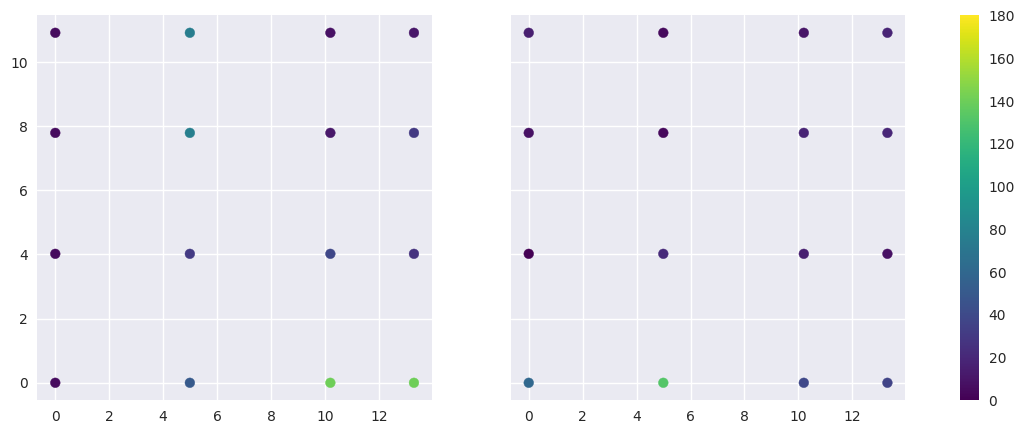

In [100]:
zeroed_target = lab_results[lab_results["z"] == 0]
elevated_target = lab_results[lab_results["z"] == 5.3]


fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 5))
for i, dataset in enumerate([zeroed_target, elevated_target]):
    img = axs[i].scatter(
        dataset["x"],
        dataset["y"],
        c=dataset["azimuth_delta"],
        vmin=0,
        vmax=180,
        cmap="viridis"
    )
fig.colorbar(img, ax=axs);

Measured elevation error

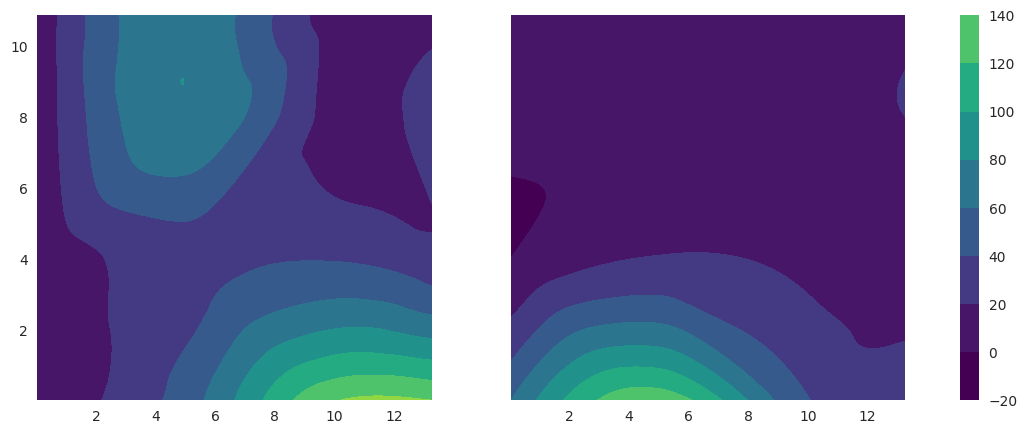

In [101]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 5))
for i, dataset in enumerate([zeroed_target, elevated_target]):
    points = dataset[["x", "y"]]
    x_max = dataset["x"].max()
    y_max = dataset["y"].max()

    grid_x, grid_y = np.mgrid[0:x_max:250j, 0:y_max:250j]
    interpolated = griddata(
        points, dataset["azimuth_delta"], (grid_x, grid_y), method="cubic"
    )
    img = axs[i].contourf(
        interpolated.T,
        vmin=0,
        vmax=180,
        extent=(0, x_max, 0, y_max),
        origin="lower",
        cmap="viridis",
    )
fig.colorbar(img, ax=axs)


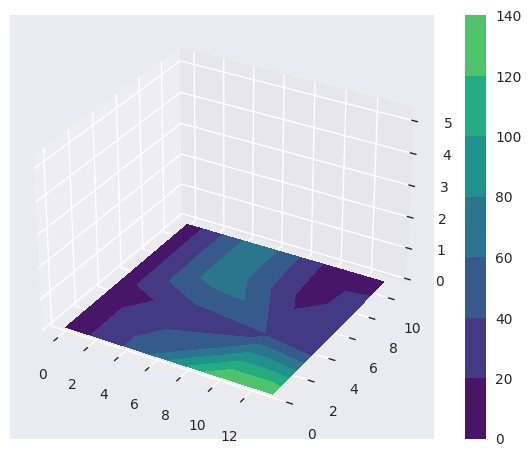

In [122]:
points = lab_results[["x", "y", "z"]]

x_max = lab_results["x"].max()
y_max = lab_results["y"].max()
z_max = lab_results["z"].max()

xs = np.linspace(0, x_max, 250)
ys = np.linspace(0, y_max, 250)
zs = np.linspace(0, z_max, 100)
grid_x, grid_y, grid_z = np.meshgrid(xs, ys, zs)

interpolated = griddata(
    points, lab_results["azimuth_delta"], (grid_x, grid_y, grid_z), method="linear"
)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

def animate(idx_z):
    global img
    z_idx, z = idx_z
    ax.cla()
    ax.set_zlim3d(0,z_max)
    img = ax.contourf(
        grid_x[:, :, 0],
        grid_y[:, :, 0],
        interpolated[:, :, z_idx],
        zdir="z",
        offset=z,
        vmin=0,
        vmax=180,
        extent=(0, x_max, 0, y_max),
        origin="lower",
        cmap="viridis"
    )
    return img.collections

anim = FuncAnimation(fig, animate, enumerate(zs))
plt.colorbar(img, ax=ax)
anim.save('error_slice.gif', fps=30, dpi=300)
